In [1]:
import matplotlib.pyplot as plt
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
# hyperparams
input_channels = 1
hidden_channels = 64
device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 3
batch_size = 128

In [3]:
os.makedirs('./data', exist_ok=True)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5)),
     ])


dataset_train = datasets.MNIST('./data', 
                               train=True,            
                               download=True, 
                               transform=transform)
trainloader = torch.utils.data.DataLoader(dataset_train, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2, 
                                          drop_last = True,)

dataset_test = datasets.MNIST('./data', 
                              train=False,
                              download=True, 
                              transform=transform)
testloader = torch.utils.data.DataLoader(dataset_train, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2, 
                                          drop_last = True,)

In [4]:
class ConvVAEncoder(nn.Module):
  #28*28 -> hidden -> hidden_out
  def __init__(self, input_ch, hidden_ch):
    super().__init__()

    self.conv1 = nn.Conv2d(input_ch, hidden_ch, kernel_size=3, stride=1, padding=1) # 28x28
    self.do1 = nn.Dropout(0.1)
    self.pool1 = nn.AvgPool2d(2, 2) # 14x14
    
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=5, stride=1, padding=2) # 14x14
    self.do2 = nn.Dropout(0.1)
    self.pool2 = nn.AvgPool2d(2, 2) # 7x7
    
    self.conv_mu = nn.Conv2d(hidden_ch, 1, kernel_size=3, stride=1, padding=1) # 7x7
    self.conv_sigma = nn.Conv2d(hidden_ch, 1, kernel_size=3, stride=1, padding=1) # 7x7
    
    self.activ = nn.ReLU()

  def forward(self, x):
    x = self.pool1(self.do1(self.activ(self.conv1(x))))
    x = self.pool2(self.do2(self.activ(self.conv2(x))))
    mu = self.conv_mu(x)
    sigma = torch.exp(self.conv_sigma(x))

    return mu, sigma

class ConvDecoder(nn.Module):
  #hidden_out-> hidden -> 28*28 
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()

    self.conv1 = nn.Conv2d(1, hidden_ch, kernel_size=3, stride=1, padding=1) # 7x7
    self.do1 = nn.Dropout(0.1)
    self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2) # 14x14
    
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=5, stride=1, padding=2) # 14x14
    self.do2 = nn.Dropout(0.1)
    self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2) # 28x28
    
    self.conv3 = nn.Conv2d(hidden_ch, input_ch, kernel_size=3, stride=1, padding=1) # 28x28
    
    self.activ = nn.ReLU()
    
  def forward(self, x):
    x = self.upsample1(self.do1(self.activ(self.conv1(x))))
    x = self.upsample2(self.do2(self.activ(self.conv2(x))))
    x = self.conv3(x)

    return x

def sampling(mu, sigma):
    return torch.normal(torch.zeros_like(mu), torch.ones_like(mu)) * sigma + mu

class ConvVAE(nn.Module):
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    self.encoder = ConvVAEncoder(input_ch, hidden_ch, )
    self.decoder = ConvDecoder(input_ch, hidden_ch, )

  def forward(self, x):
    mu, sigma = self.encoder(x)
    hidden = sampling(mu, sigma)
    x_ = self.decoder(hidden)

    return x_, mu, sigma

epoch: 00, step: 000, loss: 0.8381111621856689
epoch: 00, step: 200, loss: 0.1067337989807129
epoch: 00, step: 400, loss: 0.0941420495510101


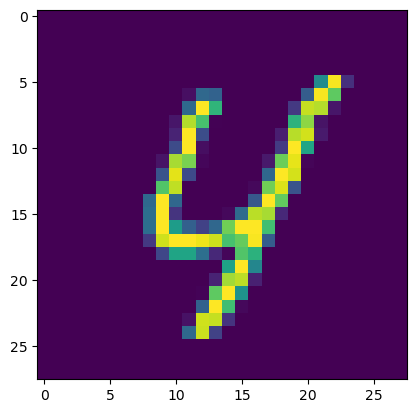

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


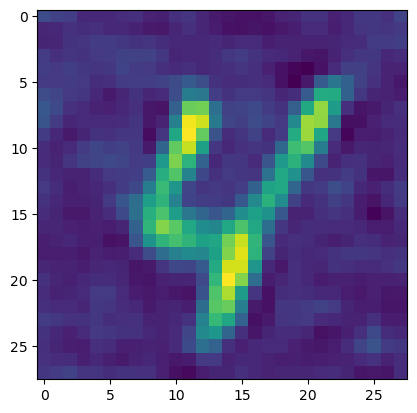

epoch: 01, step: 000, loss: 0.0879945084452629
epoch: 01, step: 200, loss: 0.0795128345489502
epoch: 01, step: 400, loss: 0.0716881006956100


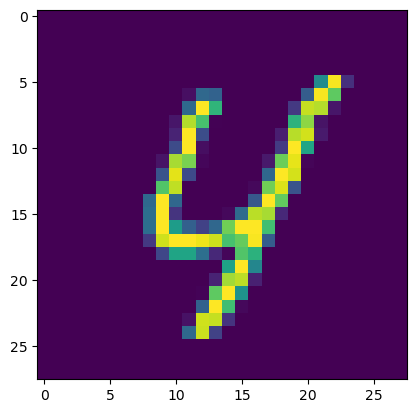

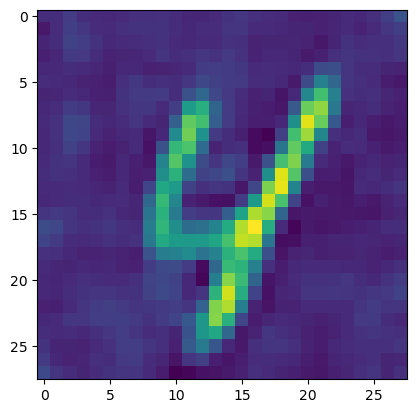

epoch: 02, step: 000, loss: 0.0753780677914619
epoch: 02, step: 200, loss: 0.0712052434682846
epoch: 02, step: 400, loss: 0.0714317411184311


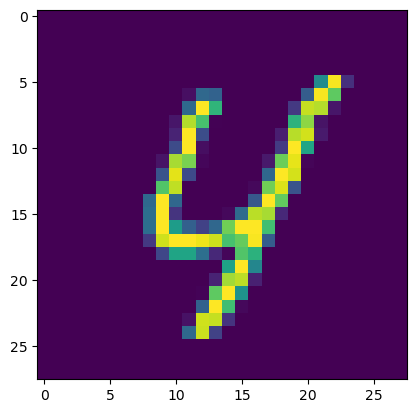

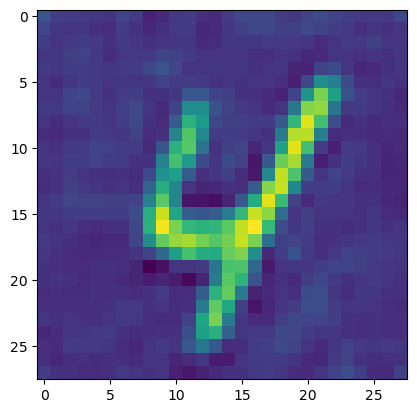

In [5]:
def kl_loss(mu, sigma):
    p = torch.distributions.Normal(mu, sigma)
    q = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(sigma))
    return torch.distributions.kl_divergence(p, q).mean()

model = ConvVAE(input_channels, hidden_channels).to(device)
optim = torch.optim.Adam(model.parameters())
loss_func = nn.MSELoss()

for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim.zero_grad()
        inputs = inputs.to(device)
        predict, mu, sigma = model(inputs)
        loss = loss_func(inputs, predict) + 0.01 * kl_loss(mu, sigma)
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch:02d}, step: {i:03d}, loss: {loss.item():.16f}')
            
    item = dataset_test[555][0].unsqueeze(0).to(device).float()
    
    plt.imshow(item.squeeze().squeeze().cpu().detach().numpy())
    plt.show()
    plt.imshow(model(item)[0].squeeze().squeeze().cpu().detach().numpy())
    plt.show()
    
    torch.save(model.state_dict(), f'./data/lin_ae_chkpt_{epoch}.pth')

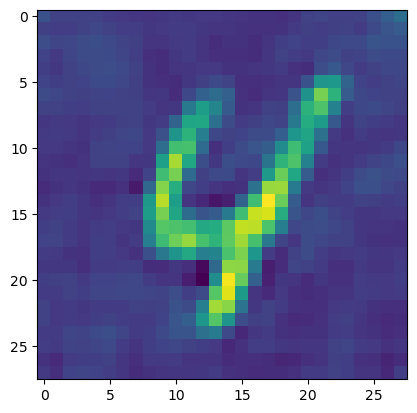

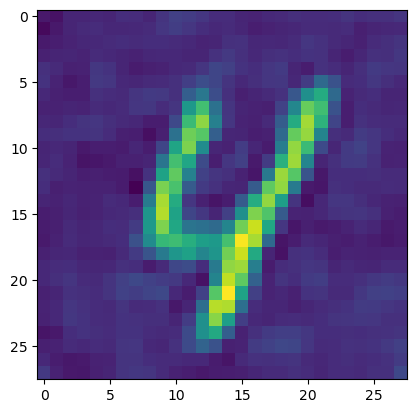

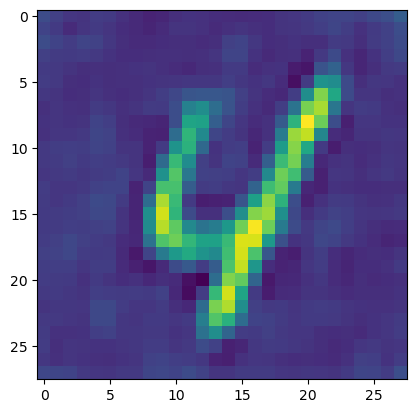

In [6]:
item = dataset_test[555][0].unsqueeze(0).to(device).float()
mu, sigma = model.encoder(item)

for _ in range(3):
    hid = torch.normal(mu, sigma).to(device)

    plt.imshow(model.decoder(hid).squeeze().squeeze().cpu().detach().numpy())
    plt.show()